# Playtesting Notebook


# Environment setup

In [1]:
# !pip -q install l5kit==1.1.0

In [2]:
# !pip -q install timm

^C
ERROR: Operation cancelled by user


In [17]:
from typing import Dict

from tempfile import gettempdir
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torch import Tensor
from torchvision.models.resnet import resnet50, resnet18, resnet34, resnet101
from tqdm import tqdm

import l5kit
from l5kit.configs import load_config_data
from l5kit.data import LocalDataManager, ChunkedDataset
from l5kit.dataset import AgentDataset, EgoDataset
from l5kit.rasterization import build_rasterizer
from l5kit.evaluation import write_pred_csv, compute_metrics_csv, read_gt_csv, create_chopped_dataset
from l5kit.evaluation.chop_dataset import MIN_FUTURE_STEPS
from l5kit.evaluation.metrics import neg_multi_log_likelihood, time_displace
from l5kit.geometry import transform_points
from l5kit.visualization import PREDICTED_POINTS_COLOR, TARGET_POINTS_COLOR, draw_trajectory
from prettytable import PrettyTable
from pathlib import Path

import matplotlib.pyplot as plt

import os
import random
import time

import warnings
warnings.filterwarnings("ignore")

In [18]:
import sys
import timm

In [19]:
l5kit.__version__

'1.1.0'

In [20]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    
set_seed(42)

## Configs

In [21]:
# --- Lyft configs ---
cfg = {
    'format_version': 4,
    'data_path': "lyft_dataset",
    'model_params': {
        'model_architecture': 'resnet34',
        'history_num_frames': 10,
        'history_step_size': 1,
        'history_delta_time': 0.1,
        'future_num_frames': 50,
        'future_step_size': 1,
        'future_delta_time': 0.1,
        'model_name': "model_resnet34_output",
        "LSTM_hidden_size": 64,
        "alpha": 0.1,
        "num_trajectories":3,
        'lr': 1e-3,
        'train': False,
        'predict': True
    },

    'raster_params': {
        'raster_size': [224, 224],
        'pixel_size': [0.5, 0.5],
        'ego_center': [0.25, 0.5],
        'map_type': 'py_semantic',
        'satellite_map_key': 'aerial_map/aerial_map.png',
        'semantic_map_key': 'semantic_map/semantic_map.pb',
        'dataset_meta_key': 'meta.json',
        'filter_agents_threshold': 0.5
    },

    'train_data_loader': {
        'key': 'scenes/train.zarr',
        'batch_size': 16,
        'shuffle': True,
        'num_workers': 4
    },
    'test_data_loader': {
        'key': 'scenes/test.zarr',
        'batch_size': 32,
        'shuffle': False,
        'num_workers': 4
    },
    'train_params': {
        'max_num_steps': 101,
        'checkpoint_every_n_steps': 20,
    }
}

Couple of things to note:

 - **model_architecture:** you can put 'resnet18', 'resnet34' or 'resnet50'. For the pretrained model we use resnet18 so we need to use 'resnet18' in the config.
 - **weight_path:** path to the pretrained model. If you don't have a pretrained model and want to train from scratch, put **weight_path** = False. 
 - **model_name:** the name of the model that will be saved as output, this is only when **train**= True.
 - **train:** True if you want to continue to train the model. Unfortunately due to Kaggle memory constraint if **train**=True then you should put **predict** = False.
 - **predict:** True if you want to predict and submit to Kaggle. Unfortunately due to Kaggle memory constraint if you want to predict then you need  to put **train** = False.
 - **lr:** learning rate of the model, feel free to change as you see fit. In the future I also plan to implement learning rate decay. 
 - **raster_size:** specify the size of the image, the default is [224,224]. Increase **raster_size** can improve the score. However the training time will be significantly longer. 
 - **batch_size:** number of inputs for one forward pass, again one of the parameters to tune. 
 - **max_num_steps:** the number of iterations to train, i.e. number of epochs.
 - **checkpoint_every_n_steps:** the model will be saved at every n steps, again change this number as to how you want to keep track of the model.

## Load the train and test data

In [8]:
# set env variable for data
DIR_INPUT = cfg["data_path"]
os.environ["L5KIT_DATA_FOLDER"] = DIR_INPUT
dm = LocalDataManager(None)

In [22]:
# ===== INIT TRAIN DATASET============================================================
train_cfg = cfg["train_data_loader"]
rasterizer = build_rasterizer(cfg, dm)
train_zarr = ChunkedDataset(dm.require(train_cfg["key"])).open()

#create mask 


train_dataset = AgentDataset(cfg, train_zarr, rasterizer)
train_dataloader = DataLoader(train_dataset, shuffle=train_cfg["shuffle"], batch_size=train_cfg["batch_size"], 
                             num_workers=train_cfg["num_workers"])
print("==================================TRAIN DATA==================================")
print(train_dataset)

==================================TRAIN DATA==================================
+------------+------------+------------+---------------+-----------------+----------------------+----------------------+----------------------+---------------------+
| Num Scenes | Num Frames | Num Agents | Num TR lights | Total Time (hr) | Avg Frames per Scene | Avg Agents per Frame | Avg Scene Time (sec) | Avg Frame frequency |
+------------+------------+------------+---------------+-----------------+----------------------+----------------------+----------------------+---------------------+
|   16265    |  4039527   | 320124624  |    38735988   |      112.19     |        248.36        |        79.25         |        24.83         |        10.00        |
+------------+------------+------------+---------------+-----------------+----------------------+----------------------+----------------------+---------------------+


In [23]:
# ===== INIT TRAIN DATASET============================================================
train_cfg = cfg["train_data_loader"]
rasterizer = build_rasterizer(cfg, dm)
train_zarr = ChunkedDataset(dm.require(train_cfg["key"])).open()

#create mask 
train_dataset_ego = EgoDataset(cfg, train_zarr, rasterizer)
train_dataloader_ego = DataLoader(train_dataset_ego, shuffle=train_cfg["shuffle"], batch_size=train_cfg["batch_size"], 
                             num_workers=train_cfg["num_workers"])
print("==================================EGO TRAIN DATA==================================")
print(train_dataset_ego)

==================================EGO TRAIN DATA==================================
+------------+------------+------------+---------------+-----------------+----------------------+----------------------+----------------------+---------------------+
| Num Scenes | Num Frames | Num Agents | Num TR lights | Total Time (hr) | Avg Frames per Scene | Avg Agents per Frame | Avg Scene Time (sec) | Avg Frame frequency |
+------------+------------+------------+---------------+-----------------+----------------------+----------------------+----------------------+---------------------+
|   16265    |  4039527   | 320124624  |    38735988   |      112.19     |        248.36        |        79.25         |        24.83         |        10.00        |
+------------+------------+------------+---------------+-----------------+----------------------+----------------------+----------------------+---------------------+


In [24]:
def pytorch_neg_multi_log_likelihood_batch(
    gt: Tensor, pred: Tensor, confidences: Tensor, avails: Tensor
) -> Tensor:
    """
    Compute a negative log-likelihood for the multi-modal scenario.
    log-sum-exp trick is used here to avoid underflow and overflow, For more information about it see:
    https://en.wikipedia.org/wiki/LogSumExp#log-sum-exp_trick_for_log-domain_calculations
    https://timvieira.github.io/blog/post/2014/02/11/exp-normalize-trick/
    https://leimao.github.io/blog/LogSumExp/
    Args:
        gt (Tensor): array of shape (bs)x(time)x(2D coords)
        pred (Tensor): array of shape (bs)x(modes)x(time)x(2D coords)
        confidences (Tensor): array of shape (bs)x(modes) with a confidence for each mode in each sample
        avails (Tensor): array of shape (bs)x(time) with the availability for each gt timestep
    Returns:
        Tensor: negative log-likelihood for this example, a single float number
    """
    assert len(pred.shape) == 4, f"expected 3D (MxTxC) array for pred, got {pred.shape}"
    batch_size, num_modes, future_len, num_coords = pred.shape

    assert gt.shape == (batch_size, future_len, num_coords), f"expected 2D (Time x Coords) array for gt, got {gt.shape}"
    assert confidences.shape == (batch_size, num_modes), f"expected 1D (Modes) array for gt, got {confidences.shape}"
    assert torch.allclose(torch.sum(confidences, dim=1), confidences.new_ones((batch_size,))), "confidences should sum to 1"
    assert avails.shape == (batch_size, future_len), f"expected 1D (Time) array for gt, got {avails.shape}"
    # assert all data are valid
    assert torch.isfinite(pred).all(), "invalid value found in pred"
    assert torch.isfinite(gt).all(), "invalid value found in gt"
    assert torch.isfinite(confidences).all(), "invalid value found in confidences"
    assert torch.isfinite(avails).all(), "invalid value found in avails"

    # convert to (batch_size, num_modes, future_len, num_coords)
    gt = torch.unsqueeze(gt, 1)  # add modes
    avails = avails[:, None, :, None]  # add modes and cords

    # error (batch_size, num_modes, future_len)
    error = torch.sum(((gt - pred) * avails) ** 2, dim=-1)  # reduce coords and use availability

    with np.errstate(divide="ignore"):  # when confidence is 0 log goes to -inf, but we're fine with it
        # error (batch_size, num_modes)
        error = torch.log(confidences + 1e-10) - 0.5 * torch.sum(error, dim=-1)  # reduce time

    # use max aggregator on modes for numerical stability
    # error (batch_size, num_modes)
    max_value, _ = error.max(dim=1, keepdim=True)  # error are negative at this point, so max() gives the minimum one
    error = -torch.log(torch.sum(torch.exp(error - max_value), dim=-1, keepdim=True)) - max_value  # reduce modes
    # print("error", error)
    return torch.mean(error)


In [25]:
from typing import List, Optional, Tuple

def get_agent_context(
        state_index: int,
        frames: np.ndarray,
        agents: np.ndarray,
#         tl_faces: np.ndarray,
        history_num_frames: int,
        future_num_frames: int,
) -> Tuple[np.ndarray, np.ndarray, List[np.ndarray], List[np.ndarray]]:
    """
    Slice zarr or numpy arrays to get the context around the agent onf interest (both in space and time)
    Args:
        state_index (int): frame index inside the scene
        frames (np.ndarray): frames from the scene
        agents (np.ndarray): agents from the scene
        tl_faces (np.ndarray): tl_faces from the scene
        history_num_frames (int): how many frames in the past to slice
        future_num_frames (int): how many frames in the future to slice
    Returns:
        Tuple[np.ndarray, np.ndarray, List[np.ndarray], List[np.ndarray], List[np.ndarray], List[np.ndarray]]
    """

    #  the history slice is ordered starting from the latest frame and goes backward in time., ex. slice(100, 91, -2)
    history_slice = l5kit.sampling.slicing.get_history_slice(state_index, history_num_frames, 1, include_current_state=True)
    future_slice = l5kit.sampling.slicing.get_future_slice(state_index, future_num_frames, 1)
    history_frames = frames[history_slice].copy()  # copy() required if the object is a np.ndarray
    future_frames = frames[future_slice].copy()
    sorted_frames = np.concatenate((history_frames[::-1], future_frames))  # from past to future

    # get agents (past and future)
    agent_slice = l5kit.data.filter.get_agents_slice_from_frames(sorted_frames[0], sorted_frames[-1])
    agents = agents[agent_slice].copy()
    # sync interval with the agents array
    history_frames["agent_index_interval"] -= agent_slice.start
    future_frames["agent_index_interval"] -= agent_slice.start
    history_agents = l5kit.data.filter.filter_agents_by_frames(history_frames, agents)
    future_agents = l5kit.data.filter.filter_agents_by_frames(future_frames, agents)
#     print("agents {}".format(agent_slice))

#     # get traffic lights (past and future)
#     tl_slice = get_tl_faces_slice_from_frames(sorted_frames[0], sorted_frames[-1])
#     tl_faces = tl_faces[tl_slice].copy()
#     # sync interval with the traffic light faces array
#     history_frames["traffic_light_faces_index_interval"] -= tl_slice.start
#     future_frames["traffic_light_faces_index_interval"] -= tl_slice.start
#     history_tl_faces = filter_tl_faces_by_frames(history_frames, tl_faces)
#     future_tl_faces = filter_tl_faces_by_frames(future_frames, tl_faces)
    return history_frames, future_frames, history_agents, future_agents #, history_tl_faces, future_tl_faces


In [26]:
import bisect

def get_agent_data(index, ego_dataset, agent_dataset):
    if index < 0:
        if -index > len(agent_dataset):
            raise ValueError("absolute value of index should not exceed dataset length")
        index = len(agent_dataset) + index
        index = agent_dataset.agents_indices[index]

    frame_index = bisect.bisect_right(agent_dataset.cumulative_sizes_agents, index)
    scene_index = bisect.bisect_right(agent_dataset.cumulative_sizes, frame_index)
    if scene_index == 0:
        state_index = frame_index
    else:
        state_index = frame_index - agent_dataset.cumulative_sizes[scene_index - 1]
    frames = ego_dataset.dataset.frames[l5kit.data.filter.get_frames_slice_from_scenes(ego_dataset.dataset.scenes[scene_index])]

    agents = ego_dataset.dataset.agents
    x = get_agent_context(state_index, frames, agents, history_num_frames= 10, future_num_frames = 50)
    return x[2]

In [27]:
data, indices = next(iter(train_dataloader))  

In [28]:
def _data_preprocessing(data, index, ego_dataset, agent_dataset):
    nbrs_batch = torch.zeros(0, 0, 10, 4) #B x N x H x 4 

    #N and H may change 
    tot_nbrs = []
    for i, scene_id in enumerate(indices):
        nbrs = torch.zeros(0, 10, 4)
        agent_data = get_agent_data(scene_id, ego_dataset, agent_dataset)
        cur_agents = agent_data[0]
        filtered_agents = l5kit.data.filter.filter_agents_by_labels(cur_agents, 0.5)
        curr_valid_agents = filtered_agents["track_id"]  
        for agent_id in curr_valid_agents:
            agent_history = []
            for frame in agent_data:
                agent_id_index = np.where(frame["track_id"] == agent_id)
                if len(agent_id_index[0]) > 0:
                    pos = (frame["centroid"][agent_id_index]).reshape(2, ) 
                    vel = (frame["velocity"][agent_id_index]).reshape(2, )  
                    state_node = np.hstack([pos, vel])
                    agent_history.append(state_node)   
                    
            agent_history_arr = np.array(agent_history)[:-1]  
            if agent_history_arr.shape != (10, 4): continue 
                
            agent_history_arr = np.flip(agent_history_arr, axis=0).copy() 
            new_hist = torch.from_numpy(agent_history_arr.reshape(1, 10, 4)) 
            nbrs = torch.cat((nbrs, new_hist), axis = 0)
        
        tot_nbrs.append(nbrs)  
        
    nbrs_batch = torch.nn.utils.rnn.pad_sequence(tuple(tot_nbrs), batch_first=True, padding_value=float('inf'))   
    ego_hist = data["history_positions"][:,:-1]
    ego_hist = ego_hist[torch.arange(ego_hist.shape[0]).unsqueeze(-1), data["history_availabilities"][:,:-1].long()] 
    nbrs_current_mask = data["image"][:,cfg["model_params"]["history_num_frames"]+1,:,:]
    
    return nbrs_batch, ego_hist 

In [29]:
nbrs_batch, ego_hist  = _data_preprocessing(data, indices, train_dataset_ego, train_dataset)

In [30]:
num_valid_agents = nbrs_batch.shape[1] 
print(num_valid_agents)    
num_edges_attrs = (num_valid_agents) * (num_valid_agents - 1) / 2

37


In [35]:
agent_from_world = data["agent_from_world"]   
#nodes --> agent reference frame 
#edges --> encode the distance between agents 
# --> relative positions of the agents


tensor([[[ 6.7243e-01, -7.4016e-01, -8.0901e+01],
         [ 7.4016e-01,  6.7243e-01, -2.1321e+02],
         [ 0.0000e+00,  0.0000e+00,  1.0000e+00]],

        [[ 6.8879e-01, -7.2496e-01,  1.0496e+03],
         [ 7.2496e-01,  6.8879e-01, -2.2548e+02],
         [ 0.0000e+00,  0.0000e+00,  1.0000e+00]],

        [[-6.9322e-01,  7.2073e-01, -1.1374e+03],
         [-7.2073e-01, -6.9322e-01,  2.6021e+02],
         [ 0.0000e+00,  0.0000e+00,  1.0000e+00]],

        [[-6.8527e-01,  7.2829e-01,  2.5720e+01],
         [-7.2829e-01, -6.8527e-01,  2.2529e+02],
         [ 0.0000e+00,  0.0000e+00,  1.0000e+00]],

        [[-6.7768e-01,  7.3536e-01, -9.0712e+02],
         [-7.3536e-01, -6.7768e-01,  2.2888e+02],
         [ 0.0000e+00,  0.0000e+00,  1.0000e+00]],

        [[ 8.4382e-01, -5.3663e-01, -1.6411e+03],
         [ 5.3663e-01,  8.4382e-01,  7.9018e+02],
         [ 0.0000e+00,  0.0000e+00,  1.0000e+00]],

        [[ 5.7364e-01,  8.1910e-01,  6.9325e+02],
         [-8.1910e-01,  5.7364e-01,  1

In [ ]:
class RNNEncoder(nn.Module):
    def __init__(self, hidden_dim): 
        super().__init__()  
        self.hidden_dim = hidden_dim  
        
        self.encoderRNN = nn.GRU(4, self.hidden_dim, 1)
        self.encoderLinear = nn.Linear(self.hidden_dim)
        self.alpha = .1 

    def forward(self, x): 
        x = self.encoderRNN(x)
        x = F.leaky_relu(x, self.alpha)
        x = self.encoderLinear(x)

        return x 

#### num_classes = 3  

In [ ]:
from torch_geometric.nn import GCNConv    

class GCN(torch.nn.Module):
    def __init__(self, hidden_channels, num_classes):
        super(GCN, self).__init__() 
        self.num_classes = num_classes 
        torch.manual_seed(12345)
        self.conv1 = GCNConv(dataset.num_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, num_classes)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        return x

model = GCN(hidden_channels=16)
print(model)

In [ ]:
class TypedGCN(nn.Module): 
    def __init__(self, input_dim, hidden_channels): 
        self.input_dim = input_dim
        self.hidden_channels = hidden_channels
        torch.manual_seed(12345)
        
        slef.

In [ ]:
class RNNDecoder(nn.Module):
    def __init__(self, hidden_dim): 
        super().__init__()  
        self.hidden_dim = hidden_dim  
        
        self.encoderRNN = nn.GRU(4, self.hidden_dim, 1)
        self.encoderLinear = nn.Linear(self.hidden_dim)
        self.alpha = .1 

    def forward(self, x): 
        x = self.encoderRNN(x)
        x = F.leaky_relu(x, self.alpha)
        x = self.encoderLinear(x)

        return x 

In [ ]:
class Net(nn.Module): 
    def __init__(self, hidden_dim_enc, hidden_dim_dec): 
        super().__init__() 
        self.hidden_dim_enc = hidden_dim_enc
        self.hidden_dim_dec = hidden_dim_dec
        
        self.rnn_encoder = RNNEncoder()
        self.rnn_decoder = RNNDecoder()
        self.graph_layer = GCN() 
        self.typed_graph_layer 
        
    def forward(self, x):

In [ ]:
hidden_dim_rnn = 64
model = RNNEncoder(hidden_dim_rnn) 
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4) 
criterion = torch.nn.MSELoss() 

In [ ]:
def train(data, max_epochs): 
    model.train()
    for _ in range(max_epochs):  
        out = model(nbrs_batch, data.edge_idx)  # Perform a single forward pass.
        loss = criterion(out[data.train_mask], data.y[data.train_mask])  # Compute the loss solely based on the training nodes.
        optimizer.zero_grad()  # Clear gradients.
        loss.backward()  # Derive gradients.
        optimizer.step()  # Update parameters based on gradients.a

    return loss  

In [ ]:
#hyperparameters
max_epochs = 1 

In [111]:
def _data_preprocess(data, index, max_agents):
    
    nbrs_batch = np.zeros(0, max_agents, 10, 4) 
    num_valid_agents_batch = [] 
    
    #posvel tensor --> B,N,H,4 
    max_num_agents = float('inf')
    for i, scene_id in enumerate(tqdm(indices)):   
        agent_data = get_agent_data(scene_id)
        cur_agents = agent_data[0]
        filtered_agents = l5kit.data.filter.filter_agents_by_labels(cur_agents, 0.5)
        curr_valid_agents = filtered_agents["track_id"]    
        num_valid_agents_batch.append(len(curr_valid_agents))

        if len(curr_valid_agents) > max_num_agents: 
            max_num_agents = len(curr_valid_agents) 
        
        for agent_id in curr_valid_agents:
            agent_history = []
            for frame in agent_data:
                agent_id_index = np.where(frame["track_id"] == agent_id)
                if len(agent_id_index[0]) > 0: 
                    pos = (frame["centroid"][agent_id_index]).reshape(2, )
                    vel = (frame["velocity"][agent_id_index]).reshape(2, )
                    state_node = np.hstack([pos, vel])
                    agent_history.append(state_node)
                        
            agent_history_arr = np.array(agent_history)[:-1] #(10, 4)   
            if agent_history_arr.shape != (10, 4): continue  
            nbrs_b_arr = np.array(nbrs_b.append(agent_history_arr)) 
            print(agent_history_arr.shape)
            #agent_history_arr_ten = torch.from_numpy(agent_history_arr.reshape(1, 10, 4))     
            #nbrs_batch = torch.cat((nbrs_batch, agent_history_arr_ten), axis = 0)    
         
    ego_hist = data["history_positions"][:,:-1]
    ego_hist = ego_hist[torch.arange(ego_hist.shape[0]).unsqueeze(-1), data["history_availabilities"][:,:-1].long()] 
    nbrs_current_mask = data["image"][:,cfg["model_params"]["history_num_frames"]+1,:,:]

    return nbrs_batch, ego_hist, num_valid_agents_batch

In [112]:
nbrs_states, ego_state, num_valid_agents_batch = _data_preprocess(data, indices) 

 31%|███▏      | 5/16 [00:00<00:00, 44.97it/s]

(10, 4)
(10, 4)
(10, 4)
(10, 4)
(10, 4)
(10, 4)
(10, 4)
(10, 4)
(10, 4)
(10, 4)
(10, 4)
(10, 4)
(10, 4)
(10, 4)
(10, 4)
(10, 4)
(10, 4)
(10, 4)
(10, 4)
(10, 4)
(10, 4)
(10, 4)
(10, 4)
(10, 4)
(10, 4)
(10, 4)
(10, 4)
(10, 4)
(10, 4)
(10, 4)
(10, 4)
(10, 4)
(10, 4)
(10, 4)
(10, 4)
(10, 4)
(10, 4)
(10, 4)
(10, 4)
(10, 4)
(10, 4)
(10, 4)
(10, 4)
(10, 4)
(10, 4)
(10, 4)
(10, 4)
(10, 4)
(10, 4)
(10, 4)
(10, 4)
(10, 4)
(10, 4)
(10, 4)
(10, 4)
(10, 4)
(10, 4)
(10, 4)
(10, 4)
(10, 4)
(10, 4)
(10, 4)
(10, 4)
(10, 4)
(10, 4)
(10, 4)
(10, 4)
(10, 4)
(10, 4)
(10, 4)
(10, 4)
(10, 4)
(10, 4)
(10, 4)
(10, 4)
(10, 4)
(10, 4)
(10, 4)
(10, 4)
(10, 4)
(10, 4)
(10, 4)
(10, 4)
(10, 4)
(10, 4)
(10, 4)
(10, 4)
(10, 4)
(10, 4)
(10, 4)
(10, 4)
(10, 4)
(10, 4)
(10, 4)
(10, 4)
(10, 4)
(10, 4)
(10, 4)
(10, 4)
(10, 4)
(10, 4)
(10, 4)
(10, 4)
(10, 4)
(10, 4)
(10, 4)
(10, 4)
(10, 4)
(10, 4)
(10, 4)
(10, 4)
(10, 4)
(10, 4)
(10, 4)
(10, 4)
(10, 4)
(10, 4)
(10, 4)
(10, 4)
(10, 4)
(10, 4)
(10, 4)
(10, 4)
(10, 4)
(10, 4)


100%|██████████| 16/16 [00:00<00:00, 47.98it/s]

(10, 4)
(10, 4)
(10, 4)
(10, 4)
(10, 4)
(10, 4)
(10, 4)
(10, 4)
(10, 4)
(10, 4)
(10, 4)
(10, 4)
(10, 4)
(10, 4)
(10, 4)
(10, 4)
(10, 4)
(10, 4)
(10, 4)
(10, 4)
(10, 4)
(10, 4)
(10, 4)
(10, 4)
(10, 4)
(10, 4)
(10, 4)
(10, 4)
(10, 4)
(10, 4)
(10, 4)
(10, 4)
(10, 4)
(10, 4)
(10, 4)
(10, 4)
(10, 4)
(10, 4)
(10, 4)
(10, 4)
(10, 4)
(10, 4)
(10, 4)
(10, 4)
(10, 4)
(10, 4)
(10, 4)
(10, 4)
(10, 4)
(10, 4)
(10, 4)
(10, 4)
(10, 4)
(10, 4)
(10, 4)
(10, 4)
(10, 4)
(10, 4)
(10, 4)
(10, 4)
(10, 4)
(10, 4)
(10, 4)
(10, 4)
(10, 4)
(10, 4)
(10, 4)
(10, 4)
(10, 4)
(10, 4)
(10, 4)
(10, 4)
(10, 4)
(10, 4)
(10, 4)
(10, 4)
(10, 4)
(10, 4)
(10, 4)
(10, 4)
(10, 4)
(10, 4)
(10, 4)
(10, 4)
(10, 4)
(10, 4)
(10, 4)
(10, 4)
(10, 4)
(10, 4)
(10, 4)
(10, 4)
(10, 4)
(10, 4)
(10, 4)
(10, 4)
(10, 4)
(10, 4)
(10, 4)
(10, 4)
(10, 4)
(10, 4)
(10, 4)
(10, 4)
(10, 4)
(10, 4)
(10, 4)
(10, 4)
(10, 4)
(10, 4)
(10, 4)
(10, 4)
(10, 4)
(10, 4)
(10, 4)
(10, 4)
(10, 4)
(10, 4)
(10, 4)
(10, 4)
(10, 4)
(10, 4)
(10, 4)
(10, 4)
(10, 4)


In [106]:
nbrs_per_batch = np.shape(())
s = 0 
for i in range(len(num_valid_agents_batch)):     
    end = s + num_valid_agents_batch[i]    
    x = nbrs_states[s:end :, :]    
    print(x.shape) 
    s = end

torch.Size([39, 10, 4])
torch.Size([16, 10, 4])
torch.Size([65, 10, 4])
torch.Size([25, 10, 4])
torch.Size([34, 10, 4])
torch.Size([38, 10, 4])
torch.Size([49, 10, 4])
torch.Size([34, 10, 4])
torch.Size([24, 10, 4])
torch.Size([47, 10, 4])
torch.Size([13, 10, 4])
torch.Size([0, 10, 4])
torch.Size([0, 10, 4])
torch.Size([0, 10, 4])
torch.Size([0, 10, 4])
torch.Size([0, 10, 4])


In [104]:
nbrs_states.shape

torch.Size([384, 10, 4])

In [75]:
from scipy.spatial.distance import cdist 

fc = lambda a : a*(a-1)
num_edge_attrs_batch = fc(num_valid_agents_batch)    
for i in range(nbrs_states.shape[0]): 
    C = cdist(nbrs_states[i, :, :], nbrs_states[i, :, :])  

print(nbrs_states.shape) 


torch.Size([384, 10, 4])


In [46]:
device = "cuda"
criterion = pytorch_neg_multi_log_likelihood_batch
model = CSP(cfg, device).to(device)

## RNN

In [ ]:
class RNNDecoder(nn.Module):
    def __init__(self, hidden_dim): 
        super().__init__() 
        self.hidden_dim = hidden_dim 

        self.encoderRNN = nn.GRU(2, self.hidden_dim, 1)
        self.encoderLinear = nn.Linear(self.hidden_dim)
        self.alpha = .1 

    def forward(self, x):
        x = self.encoderRNN(x)
        x = F.leaky_relu(x, self.alpha)
        x = self.encoderLinear(x)

        return x 

## GNN

In [ ]:
model = GCN(hidden_channels=16)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()

def train():
      model.train()
      optimizer.zero_grad()  # Clear gradients.
      out = model(data.x, data.edge_idx)  # Perform a single forward pass.
      loss = criterion(out[data.train_mask], data.y[data.train_mask])  # Compute the loss solely based on the training nodes.
      loss.backward()  # Derive gradients.
      optimizer.step()  # Update parameters based on gradients.
      return loss 

def test():
      model.eval()
      out = model(data.x, data.edge_index)
      pred = out.argmax(dim=1)  # Use the class with highest probability.
      test_correct = pred[data.test_mask] == data.y[data.test_mask]  # Check against ground-truth labels.
      test_acc = int(test_correct.sum()) / int(data.test_mask.sum())  # Derive ratio of correct predictions.
      return test_acc


for epoch in range(1, 201):
    loss = train()
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')

In [49]:
forward(data, indices, model, criterion, device = device)

100%|██████████| 16/16 [00:00<00:00, 117.57it/s]


Loss 9626.6396484375


(tensor(9626.6396, device='cuda:0', grad_fn=<MeanBackward0>),
 tensor([[[[ 0.0198,  0.0173],
           [ 0.0507,  0.0347],
           [ 0.1295,  0.1059],
           ...,
           [-0.0856, -0.1495],
           [-0.0716,  0.0952],
           [ 0.0111,  0.0039]],
 
          [[ 0.1659,  0.1489],
           [ 0.1572,  0.0657],
           [-0.0478, -0.0740],
           ...,
           [ 0.1801, -0.1244],
           [ 0.1174, -0.0652],
           [-0.0662,  0.1754]],
 
          [[ 0.0336,  0.0868],
           [ 0.1708,  0.1618],
           [-0.0027,  0.1906],
           ...,
           [ 0.1622,  0.1722],
           [-0.1558,  0.1338],
           [ 0.0939,  0.0718]]],
 
 
         [[[ 0.0198,  0.0173],
           [ 0.0507,  0.0347],
           [ 0.1295,  0.1059],
           ...,
           [-0.0856, -0.1495],
           [-0.0716,  0.0952],
           [ 0.0111,  0.0039]],
 
          [[ 0.1659,  0.1489],
           [ 0.1572,  0.0657],
           [-0.0478, -0.0740],
           ...,
      

In [ ]:
model = GCN(hidden_channels=16)
model.eval()

out = model(data.x, data.edge_index)
visualize(out, color=data.y)

In [293]:
nbrs_hist = im[:,0:cfg["model_params"]["history_num_frames"]+1,:,:]
ego_hist = im[:,cfg["model_params"]["history_num_frames"]+1:2*(cfg["model_params"]["history_num_frames"]+1):,:]

NameError: name 'im' is not defined

In [59]:
ego_hist = data["history_positions"].shape
nbrs_hist = ??

torch.Size([16, 11, 2])

In [62]:
data["target_positions"].shape

torch.Size([16, 50, 2])

## Simple visualization

Let us visualize how an input to the model looks like.

In [13]:
def visualize_trajectory(dataset, index, title="target_positions movement with draw_trajectory"):
    data = dataset[index]
    im = data["image"].transpose(1, 2, 0)
    print(im.shape)
    im = dataset.rasterizer.to_rgb(im)
    target_positions_pixels = transform_points(data["target_positions"] + data["centroid"][:2], data["world_to_image"])
    draw_trajectory(im, target_positions_pixels, TARGET_POINTS_COLOR, radius=1, yaws=data["target_yaws"])

    plt.title(title)
    plt.imshow(im[::-1])
    plt.show()

(224, 224, 25)


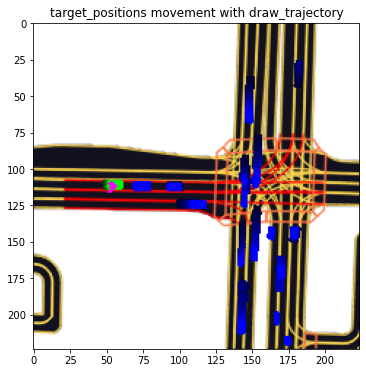

In [14]:
plt.figure(figsize = (8,6))
visualize_trajectory(train_dataset, index=90)

## Loss function

For this competition it is important to use the correct loss function when train the model. Our goal is to predict three possible paths together with the confidence score, so we need to use the loss function that takes that into account, simply using RMSE will not lead to an accurate model. More information about the loss function can be found here [negative log likelihood](https://github.com/lyft/l5kit/blob/master/competition.md).

In [15]:
# --- Function utils ---
# Original code from https://github.com/lyft/l5kit/blob/20ab033c01610d711c3d36e1963ecec86e8b85b6/l5kit/l5kit/evaluation/metrics.py
import numpy as np

import torch
from torch import Tensor


def pytorch_neg_multi_log_likelihood_batch(
    gt: Tensor, pred: Tensor, confidences: Tensor, avails: Tensor
) -> Tensor:
    """
    Compute a negative log-likelihood for the multi-modal scenario.
    log-sum-exp trick is used here to avoid underflow and overflow, For more information about it see:
    https://en.wikipedia.org/wiki/LogSumExp#log-sum-exp_trick_for_log-domain_calculations
    https://timvieira.github.io/blog/post/2014/02/11/exp-normalize-trick/
    https://leimao.github.io/blog/LogSumExp/
    Args:
        gt (Tensor): array of shape (bs)x(time)x(2D coords)
        pred (Tensor): array of shape (bs)x(modes)x(time)x(2D coords)
        confidences (Tensor): array of shape (bs)x(modes) with a confidence for each mode in each sample
        avails (Tensor): array of shape (bs)x(time) with the availability for each gt timestep
    Returns:
        Tensor: negative log-likelihood for this example, a single float number
    """
    assert len(pred.shape) == 4, f"expected 3D (MxTxC) array for pred, got {pred.shape}"
    batch_size, num_modes, future_len, num_coords = pred.shape

    assert gt.shape == (batch_size, future_len, num_coords), f"expected 2D (Time x Coords) array for gt, got {gt.shape}"
    assert confidences.shape == (batch_size, num_modes), f"expected 1D (Modes) array for gt, got {confidences.shape}"
    assert torch.allclose(torch.sum(confidences, dim=1), confidences.new_ones((batch_size,))), "confidences should sum to 1"
    assert avails.shape == (batch_size, future_len), f"expected 1D (Time) array for gt, got {avails.shape}"
    # assert all data are valid
    assert torch.isfinite(pred).all(), "invalid value found in pred"
    assert torch.isfinite(gt).all(), "invalid value found in gt"
    assert torch.isfinite(confidences).all(), "invalid value found in confidences"
    assert torch.isfinite(avails).all(), "invalid value found in avails"

    # convert to (batch_size, num_modes, future_len, num_coords)
    gt = torch.unsqueeze(gt, 1)  # add modes
    avails = avails[:, None, :, None]  # add modes and cords

    # error (batch_size, num_modes, future_len)
    error = torch.sum(((gt - pred) * avails) ** 2, dim=-1)  # reduce coords and use availability

    with np.errstate(divide="ignore"):  # when confidence is 0 log goes to -inf, but we're fine with it
        # error (batch_size, num_modes)
        error = torch.log(confidences) - 0.5 * torch.sum(error, dim=-1)  # reduce time

    # use max aggregator on modes for numerical stability
    # error (batch_size, num_modes)
    max_value, _ = error.max(dim=1, keepdim=True)  # error are negative at this point, so max() gives the minimum one
    error = -torch.log(torch.sum(torch.exp(error - max_value), dim=-1, keepdim=True)) - max_value  # reduce modes
    # print("error", error)
    return torch.mean(error)


def pytorch_neg_multi_log_likelihood_single(
    gt: Tensor, pred: Tensor, avails: Tensor
) -> Tensor:
    """

    Args:
        gt (Tensor): array of shape (bs)x(time)x(2D coords)
        pred (Tensor): array of shape (bs)x(time)x(2D coords)
        avails (Tensor): array of shape (bs)x(time) with the availability for each gt timestep
    Returns:
        Tensor: negative log-likelihood for this example, a single float number
    """
    # pred (bs)x(time)x(2D coords) --> (bs)x(mode=1)x(time)x(2D coords)
    # create confidence (bs)x(mode=1)
    batch_size, future_len, num_coords = pred.shape
    confidences = pred.new_ones((batch_size, 1))
    return pytorch_neg_multi_log_likelihood_batch(gt, pred.unsqueeze(1), confidences, avails)

## Roshan's Model

In [16]:
class SimpleNet(nn.Module):
    def __init__(self, cfg):
        super(SimpleNet, self).__init__()
        num_targets = 2 * cfg["model_params"]["future_num_frames"]
        self.net = nn.Sequential(nn.Conv2d(25, 5, kernel_size = 3, padding=1),
                                 nn.ReLU(),
                                 nn.Conv2d(5, 2, kernel_size = 3, padding=1),
                                 nn.Flatten(),
                                 nn.Linear(224*224*2, num_targets)
                                 )
    def forward(self, x):
        x = self.net(x)
        return x

In [17]:
class ConvNet1(nn.Module):
    def __init__(self, cfg, backbone):
        super().__init__()
        
        num_targets = 2 * cfg["model_params"]["future_num_frames"]
        self.backbone = timm.create_model(backbone, pretrained=True, in_chans=25)
        if backbone == "xception41":
            num_out_backbone = 1000
        self.fc1 = nn.Linear(num_out_backbone, num_targets)
    
    def forward(self, x):
        x = self.backbone(x)
        x = F.relu(x)
        x = self.fc1(x)
        return x

In [18]:
def forward(data, model, device, criterion):
    inputs = data["image"].to(device)
    target_availabilities = data["target_availabilities"].unsqueeze(-1).to(device)
    targets = data["target_positions"].to(device)
    # Forward pass
    outputs = model(inputs).reshape(targets.shape)
    loss = criterion(outputs, targets)
    # not all the output steps are valid, but we can filter them out from the loss using availabilities
    loss = loss * target_availabilities
    loss = loss.mean()
    return loss, outputs

In [19]:
# ==== INIT MODEL
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = torch.load("models/ComplexNet1v1.pt")

In [20]:
# ==== INIT MODEL
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# model = ConvNet1(cfg, backbone="xception41").to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss(reduction="none")

In [89]:
# ==== TRAIN LOOP
tr_it = iter(train_dataloader)
progress_bar = tqdm(range(400))
losses_train = []
for _ in progress_bar:
    try:
        data = next(tr_it)
    except StopIteration:
        tr_it = iter(train_dataloader)
        data = next(tr_it)
    model.train()
    torch.set_grad_enabled(True)
    loss, out = forward(data, model, device, criterion)

    # Backward pass
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    losses_train.append(loss.item())
    progress_bar.set_description(f"loss: {loss.item()} loss(avg): {np.mean(losses_train)}")

loss: 1.7263625860214233 loss(avg): 17.634183143898845: 100%|██████████| 400/400 [04:55<00:00,  1.35it/s]


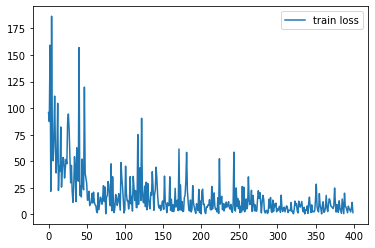

In [90]:
plt.plot(np.arange(len(losses_train)), losses_train, label="train loss")
plt.legend()
plt.show()

In [22]:
# #If CUDA out of memory:
# torch.cuda.empty_cache()

In [93]:
torch.save(model, "models/ComplexNet1v1.pt")

## Roshan's Model Eval

In [25]:
# ===== GENERATE AND LOAD CHOPPED DATASET
import shutil
eval_cfg = cfg["test_data_loader"]
!rm -rf /tmp/lyft
eval_dir = shutil.copytree(dm.require(eval_cfg["key"]), '/tmp/lyft/test.zarr')

In [26]:
num_frames_to_chop = 50
eval_base_path = create_chopped_dataset(eval_dir, cfg["raster_params"]["filter_agents_threshold"], 
                              num_frames_to_chop, cfg["model_params"]["future_num_frames"], MIN_FUTURE_STEPS)
!ls {eval_base_path}

starting pool...


11314/11314: : 11314it [08:56, 21.10it/s]


collecting results..
start report for /tmp/lyft/test.zarr
{   'reject_th_AV_distance': 11657147,
    'reject_th_agent_filter_probability_threshold': 58143776,
    'reject_th_extent': 3891368,
    'reject_th_yaw': 235401,
    'th_agent_filter_probability_threshold': 0.5,
    'th_distance_av': 50,
    'th_extent_ratio': 1.1,
    'th_yaw_degree': 30,
    'total_agent_frames': 88594921,
    'total_reject': 73927692}


computing past/future table: 100%|██████████| 4/4 [00:06<00:00,  1.58s/it]


+-------------+----------+---------+---------+---------+
| past/future |    0     |    10   |    30   |    50   |
+-------------+----------+---------+---------+---------+
|      0      | 88594921 | 6228370 | 2930955 | 1492752 |
|      10     | 6228370  | 4165061 | 2095398 | 1044694 |
|      30     | 2930955  | 2095398 | 1044694 |  417097 |
|      50     | 1492752  | 1044694 |  417097 |    0    |
+-------------+----------+---------+---------+---------+
end report for /tmp/lyft/test.zarr


extracting GT: 100%|██████████| 70125/70125 [07:07<00:00, 164.21it/s]


gt.csv	mask.npz  test.zarr


In [ ]:
eval_base_path

In [23]:
eval_zarr_path = str(Path(eval_base_path) / "test.zarr")
eval_mask_path = str(Path(eval_base_path) / "mask.npz")
eval_gt_path = str(Path(eval_base_path) / "gt.csv")

NameError: name 'eval_base_path' is not defined

In [22]:
eval_zarr = ChunkedDataset(eval_zarr_path).open()
eval_mask = np.load(eval_mask_path)["arr_0"]
# ===== INIT DATASET AND LOAD MASK
eval_dataset = AgentDataset(cfg, eval_zarr, rasterizer, agents_mask=eval_mask)
eval_dataloader = DataLoader(eval_dataset, shuffle=eval_cfg["shuffle"], batch_size=eval_cfg["batch_size"], 
                             num_workers=eval_cfg["num_workers"])

NameError: name 'eval_zarr_path' is not defined

In [21]:
# ==== EVAL LOOP
model.eval()
torch.set_grad_enabled(False)

# store information for evaluation
future_coords_offsets_pd = []
timestamps = []
agent_ids = []

progress_bar = tqdm(eval_dataloader)
for data in progress_bar:
    _, outputs = forward(data, model, device, criterion)
    
    # convert agent coordinates into world offsets
    agents_coords = outputs.cpu().numpy()[0].squeeze()
    world_from_agents = data["world_from_agent"].numpy()[0].squeeze()
    centroids = data["centroid"].numpy()
    coords_offset = transform_points(agents_coords, world_from_agents) - centroids[:, None, :2]
    future_coords_offsets_pd.append(np.stack(coords_offset))
    timestamps.append(data["timestamp"].numpy().copy())
    agent_ids.append(data["track_id"].numpy().copy())

NameError: name 'eval_dataloader' is not defined

In [123]:
pred_path = f"{gettempdir()}/pred.csv"

write_pred_csv(pred_path,
               timestamps=np.concatenate(timestamps),
               track_ids=np.concatenate(agent_ids),
               coords=np.concatenate(future_coords_offsets_pd),
              )

In [124]:
metrics = compute_metrics_csv(eval_gt_path, pred_path, [neg_multi_log_likelihood, time_displace])
for metric_name, metric_mean in metrics.items():
    print(metric_name, metric_mean)
#Need to refactor this a bit if we're outputting multiple trajectories with confidences

neg_multi_log_likelihood 7008575.044790805
time_displace [362.58989468 362.53331318 362.57375794 362.57201712 362.56728084
 362.60386749 362.64453199 362.68124286 362.71572618 362.75152972
 361.55697588 360.56117614 359.5599973  358.53505468 357.59042231
 356.39865873 355.32198813 354.04933612 352.57075258 350.97582746
 349.41000166 347.68481294 345.74257351 344.04874313 341.94160077
 340.01188497 337.65957188 335.66147725 333.35438795 331.22323374
 328.78443814 326.39899842 323.95147188 321.77494158 319.2378786
 316.87624581 314.12052021 311.473457   308.68667243 305.66723409
 303.19899789 300.74223726 298.18079678 295.5987075  293.15767866
 290.66831368 288.16203824 285.91840645 283.73711384 280.85689576]


## Model

Next we define the baseline model. Note that this model will return three possible trajectories together with confidence score for each trajectory.

In [19]:
class LyftMultiModel(nn.Module):

    def __init__(self, cfg: Dict, num_modes=3):
        super().__init__()

        architecture = cfg["model_params"]["model_architecture"]
        backbone = eval(architecture)(pretrained=True, progress=True)
        self.backbone = backbone

        num_history_channels = (cfg["model_params"]["history_num_frames"] + 1) * 2
        num_in_channels = 3 + num_history_channels

        self.backbone.conv1 = nn.Conv2d(
            num_in_channels,
            self.backbone.conv1.out_channels,
            kernel_size=self.backbone.conv1.kernel_size,
            stride=self.backbone.conv1.stride,
            padding=self.backbone.conv1.padding,
            bias=False,
        )

        # This is 512 for resnet18 and resnet34;
        # And it is 2048 for the other resnets
        
        if architecture == "resnet50":
            backbone_out_features = 2048
        else:
            backbone_out_features = 512

        # X, Y coords for the future positions (output shape: batch_sizex50x2)
        self.future_len = cfg["model_params"]["future_num_frames"]
        num_targets = 2 * self.future_len

        # You can add more layers here.
        self.head = nn.Sequential(
            # nn.Dropout(0.2),
            nn.Linear(in_features=backbone_out_features, out_features=4096),
        )

        self.num_preds = num_targets * num_modes
        self.num_modes = num_modes

        self.logit = nn.Linear(4096, out_features=self.num_preds + num_modes)

    def forward(self, x):
        x = self.backbone.conv1(x)
        x = self.backbone.bn1(x)
        x = self.backbone.relu(x)
        x = self.backbone.maxpool(x)

        x = self.backbone.layer1(x)
        x = self.backbone.layer2(x)
        x = self.backbone.layer3(x)
        x = self.backbone.layer4(x)

        x = self.backbone.avgpool(x)
        x = torch.flatten(x, 1)

        x = self.head(x)
        x = self.logit(x)

        # pred (batch_size)x(modes)x(time)x(2D coords)
        # confidences (batch_size)x(modes)
        bs, _ = x.shape
        pred, confidences = torch.split(x, self.num_preds, dim=1)
        pred = pred.view(bs, self.num_modes, self.future_len, 2)
        assert confidences.shape == (bs, self.num_modes)
        confidences = torch.softmax(confidences, dim=1)
        return pred, confidences

In [20]:
def forward(data, model, device, criterion = pytorch_neg_multi_log_likelihood_batch):
    inputs = data["image"].to(device)
    target_availabilities = data["target_availabilities"].to(device)
    targets = data["target_positions"].to(device)
    # Forward pass
    preds, confidences = model(inputs)
    loss = criterion(targets, preds, confidences, target_availabilities)
    return loss, preds, confidences

Now let us initialize the model and load the pretrained weights. Note that since the pretrained model was trained on GPU, you also need to enable GPU when running this notebook.

In [21]:
# ==== INIT MODEL=================
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = LyftMultiModel(cfg)

#load weight if there is a pretrained model
weight_path = cfg["model_params"]["weight_path"]
if weight_path:
    model.load_state_dict(torch.load(weight_path))

model.to(device)
optimizer = optim.Adam(model.parameters(), lr=cfg["model_params"]["lr"])
print(f'device {device}')

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /home/ubuntu/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

KeyError: 'weight_path'

In [ ]:
print(model)

## Training loop

Next let us implement the training loop, when the **train** parameter is set to True.

In [ ]:
# ==== TRAINING LOOP =========================================================
if cfg["model_params"]["train"]:
    
    tr_it = iter(train_dataloader)
    progress_bar = tqdm(range(cfg["train_params"]["max_num_steps"]))
    num_iter = cfg["train_params"]["max_num_steps"]
    losses_train = []
    iterations = []
    metrics = []
    times = []
    model_name = cfg["model_params"]["model_name"]
    start = time.time()
    for i in progress_bar:
        try:
            data = next(tr_it)
        except StopIteration:
            tr_it = iter(train_dataloader)
            data = next(tr_it)
        model.train()
        torch.set_grad_enabled(True)
        
        loss, _, _ = forward(data, model, device)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        losses_train.append(loss.item())

        progress_bar.set_description(f"loss: {loss.item()} loss(avg): {np.mean(losses_train)}")
        if i % cfg['train_params']['checkpoint_every_n_steps'] == 0:
            torch.save(model.state_dict(), f'{model_name}_{i}.pth')
            iterations.append(i)
            metrics.append(np.mean(losses_train))
            times.append((time.time()-start)/60)

    results = pd.DataFrame({'iterations': iterations, 'metrics (avg)': metrics, 'elapsed_time (mins)': times})
    results.to_csv(f"train_metrics_{model_name}_{num_iter}.csv", index = False)
    print(f"Total training time is {(time.time()-start)/60} mins")
    print(results.head())

## Prediction

Finally we implement the inference to submit to Kaggle when **predict** param is set to True.

In [ ]:
# ==== EVAL LOOP ================================================================
if cfg["model_params"]["predict"]:
    
    model.eval()
    torch.set_grad_enabled(False)

    # store information for evaluation
    future_coords_offsets_pd = []
    timestamps = []
    confidences_list = []
    agent_ids = []

    progress_bar = tqdm(test_dataloader)
    
    for data in progress_bar:
        
        _, preds, confidences = forward(data, model, device)
    
        #fix for the new environment
        preds = preds.cpu().numpy()
        world_from_agents = data["world_from_agent"].numpy()
        centroids = data["centroid"].numpy()
        coords_offset = []
        
        # convert into world coordinates and compute offsets
        for idx in range(len(preds)):
            for mode in range(3):
                preds[idx, mode, :, :] = transform_points(preds[idx, mode, :, :], world_from_agents[idx]) - centroids[idx][:2]
    
        future_coords_offsets_pd.append(preds.copy())
        confidences_list.append(confidences.cpu().numpy().copy())
        timestamps.append(data["timestamp"].numpy().copy())
        agent_ids.append(data["track_id"].numpy().copy())

In [ ]:
#create submission to submit to Kaggle
pred_path = 'submission.csv'
write_pred_csv(pred_path,
           timestamps=np.concatenate(timestamps),
           track_ids=np.concatenate(agent_ids),
           coords=np.concatenate(future_coords_offsets_pd),
           confs = np.concatenate(confidences_list)
          )